In [1]:
import pandas as pd
import time
from tqdm import tqdm
import numpy as np
import random

from gpt2outputdataset.detector_radford import DetectorRadford
from detectgpt.detector_detectgpt import DetectorDetectGPT
from detector_guo import DetectorGuo
from detector_dummy import DetectorDummy
from explainer_wrappers import LIME_Explainer, SHAP_Explainer, Anchor_Explainer
detector_classes = [DetectorGuo, DetectorRadford, DetectorDetectGPT]
explainer_classes = [  LIME_Explainer]
results = []


In [2]:
test = pd.read_pickle("./dataset_test.pkl")
train = pd.read_pickle("./dataset_train.pkl")

In [3]:
documents = test["answer"]
gold_labels = test["author"] == "human_answers"

In [4]:
detector=DetectorRadford()

In [5]:
p_mask=0.25

In [6]:
experiments = {
    "attention_mask": lambda text: " ".join([t if t != "<mask>" else detector.get_pad_token() for t in text.split(" ")]), # all share the custom mask token
    "space": lambda text: " ".join([t if t != "<mask>" else " " for t in text.split(" ")]),
    "remove": lambda text: " ".join([t  for t in text.split(" ") if t != "<mask>"]),
}

In [7]:
for e, f in experiments.items():
    print(e,f)

attention_mask <function <lambda> at 0x000001DB25C574C0>
space <function <lambda> at 0x000001DB25C57920>
remove <function <lambda> at 0x000001DB25C57420>


In [8]:
results = []
for p_mask in ["single", 0.05, 0.1, 0.25,0.5,0.8]:
    random.seed(42)
    masked_documents = None
    if p_mask != "single":
        masked_documents = [" ".join([t if random.random() > p_mask else "<mask>" for t in document.split(" ")]) for document in documents]
    else:
        masked_documents = []
        for document in documents:
            tokens = document.split(" ")
            masked_documents.append(document.replace(random.sample(tokens,1)[0], "<mask>", 1))
         
    for detector_class in detector_classes:
        detector = detector_class()
        print(detector.__class__.__name__)
        predictions_original = detector.predict_label(documents)
        for e, f in experiments.items():
            print("       ", e)
            
            predictions_masked = detector.predict_label([f(d) for d in masked_documents])

            for p_o, p_m, gt  in zip(predictions_original, predictions_masked, gold_labels):
                results.append((p_mask, detector.__class__.__name__, e, gt, p_o, p_m ))
    df = pd.DataFrame(results, columns=["p_replace", "Detector", "Experiment", "GT", "original", "masked"])
    df["changed"] = df["original"] != df["masked"]
    aa = df.groupby(["p_replace","Detector", "Experiment", "changed"]).count()["masked"]
    display(aa[ :, :, :,False] / (aa[ :, :, :,False] + aa[ :, :, :,True]))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DetectorGuo
        attention_mask
        space
        remove
DetectorRadford
        attention_mask
        space
        remove
Using cache dir ./.cache
Loading BASE model EleutherAI/pythia-70m...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MOVING BASE MODEL TO GPU...DONE (0.05s)
DONE (0.06s)
DetectorDetectGPT
        attention_mask
        space
        remove


p_replace  Detector           Experiment    
single     DetectorDetectGPT  attention_mask    0.744262
                              remove            0.816393
                              space             0.806557
           DetectorGuo        attention_mask    0.977049
                              remove                 NaN
                              space             0.898361
           DetectorRadford    attention_mask    0.872131
                              remove            0.927869
                              space             0.855738
Name: masked, dtype: float64

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DetectorGuo
        attention_mask
        space
        remove
DetectorRadford
        attention_mask
        space
        remove
Using cache dir ./.cache
Loading BASE model EleutherAI/pythia-70m...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MOVING BASE MODEL TO GPU...DONE (0.08s)
DONE (0.05s)
DetectorDetectGPT
        attention_mask
        space
        remove


The values in the array are unorderable. Pass `sort=False` to suppress this warning.


p_replace  Detector           Experiment    
0.05       DetectorDetectGPT  attention_mask    0.455738
                              remove            0.681967
                              space             0.681967
           DetectorGuo        attention_mask    0.609836
                              remove            0.990164
                              space             0.511475
           DetectorRadford    attention_mask    0.590164
                              remove            0.659016
                              space             0.878689
single     DetectorDetectGPT  attention_mask    0.744262
                              remove            0.816393
                              space             0.806557
           DetectorGuo        attention_mask    0.977049
                              remove                 NaN
                              space             0.898361
           DetectorRadford    attention_mask    0.872131
                              remove       

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DetectorGuo
        attention_mask
        space
        remove
DetectorRadford
        attention_mask
        space
        remove
Using cache dir ./.cache
Loading BASE model EleutherAI/pythia-70m...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MOVING BASE MODEL TO GPU...DONE (0.05s)
DONE (0.04s)
DetectorDetectGPT
        attention_mask
        space
        remove


The values in the array are unorderable. Pass `sort=False` to suppress this warning.


p_replace  Detector           Experiment    
0.05       DetectorDetectGPT  attention_mask    0.455738
                              remove            0.681967
                              space             0.681967
           DetectorGuo        attention_mask    0.609836
                              remove            0.990164
                              space             0.511475
           DetectorRadford    attention_mask    0.590164
                              remove            0.659016
                              space             0.878689
0.1        DetectorDetectGPT  attention_mask    0.281967
                              remove            0.534426
                              space             0.518033
           DetectorGuo        attention_mask    0.501639
                              remove            0.980328
                              space             0.491803
           DetectorRadford    attention_mask    0.524590
                              remove       

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DetectorGuo
        attention_mask
        space
        remove
DetectorRadford
        attention_mask
        space
        remove
Using cache dir ./.cache
Loading BASE model EleutherAI/pythia-70m...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MOVING BASE MODEL TO GPU...DONE (0.06s)
DONE (0.04s)
DetectorDetectGPT
        attention_mask
        space
        remove


The values in the array are unorderable. Pass `sort=False` to suppress this warning.


p_replace  Detector           Experiment    
0.05       DetectorDetectGPT  attention_mask    0.455738
                              remove            0.681967
                              space             0.681967
           DetectorGuo        attention_mask    0.609836
                              remove            0.990164
                              space             0.511475
           DetectorRadford    attention_mask    0.590164
                              remove            0.659016
                              space             0.878689
0.1        DetectorDetectGPT  attention_mask    0.281967
                              remove            0.534426
                              space             0.518033
           DetectorGuo        attention_mask    0.501639
                              remove            0.980328
                              space             0.491803
           DetectorRadford    attention_mask    0.524590
                              remove       

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DetectorGuo
        attention_mask
        space
        remove
DetectorRadford
        attention_mask
        space
        remove
Using cache dir ./.cache
Loading BASE model EleutherAI/pythia-70m...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MOVING BASE MODEL TO GPU...DONE (0.05s)
DONE (0.04s)
DetectorDetectGPT
        attention_mask
        space
        remove


The values in the array are unorderable. Pass `sort=False` to suppress this warning.


p_replace  Detector           Experiment    
0.05       DetectorDetectGPT  attention_mask    0.455738
                              remove            0.681967
                              space             0.681967
           DetectorGuo        attention_mask    0.609836
                              remove            0.990164
                              space             0.511475
           DetectorRadford    attention_mask    0.590164
                              remove            0.659016
                              space             0.878689
0.1        DetectorDetectGPT  attention_mask    0.281967
                              remove            0.534426
                              space             0.518033
           DetectorGuo        attention_mask    0.501639
                              remove            0.980328
                              space             0.491803
           DetectorRadford    attention_mask    0.524590
                              remove       

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DetectorGuo
        attention_mask
        space
        remove
DetectorRadford
        attention_mask
        space
        remove
Using cache dir ./.cache
Loading BASE model EleutherAI/pythia-70m...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


MOVING BASE MODEL TO GPU...DONE (0.05s)
DONE (0.04s)
DetectorDetectGPT
        attention_mask
        space
        remove


The values in the array are unorderable. Pass `sort=False` to suppress this warning.


p_replace  Detector           Experiment    
0.05       DetectorDetectGPT  attention_mask    0.455738
                              remove            0.681967
                              space             0.681967
           DetectorGuo        attention_mask    0.609836
                              remove            0.990164
                              space             0.511475
           DetectorRadford    attention_mask    0.590164
                              remove            0.659016
                              space             0.878689
0.1        DetectorDetectGPT  attention_mask    0.281967
                              remove            0.534426
                              space             0.518033
           DetectorGuo        attention_mask    0.501639
                              remove            0.980328
                              space             0.491803
           DetectorRadford    attention_mask    0.524590
                              remove       

In [9]:
df = pd.DataFrame(results, columns=["p_replace", "Detector", "Experiment", "GT", "original", "masked"])
#df = pd.read_pickle("./masking_test_results.pkl")
df.loc[df["p_replace"] == "single", "p_replace"] = 0.00001
df = df.sort_values(by="p_replace")

In [10]:
df["changed"] = df["original"] != df["masked"]
aa = df.groupby(["p_replace","Detector", "Experiment", "changed"]).count()["masked"]
percentage_unchanged = aa[ :, :, :,False] /df.groupby(["p_replace","Detector", "Experiment",]).count()["masked"]
display(percentage_unchanged)


p_replace  Detector           Experiment    
0.00001    DetectorDetectGPT  attention_mask    0.744262
                              remove            0.816393
                              space             0.806557
           DetectorGuo        attention_mask    0.977049
                              remove            1.000000
                              space             0.898361
           DetectorRadford    attention_mask    0.872131
                              remove            0.927869
                              space             0.855738
0.05000    DetectorDetectGPT  attention_mask    0.455738
                              remove            0.681967
                              space             0.681967
           DetectorGuo        attention_mask    0.609836
                              remove            0.990164
                              space             0.511475
           DetectorRadford    attention_mask    0.590164
                              remove       

In [11]:
import matplotlib.pylab as plt
import seaborn as sns


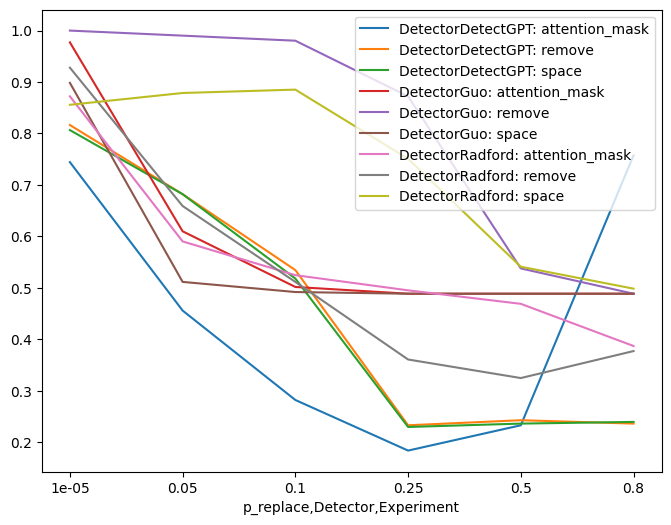

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

for name, group in percentage_unchanged.groupby(["Detector", "Experiment"]):
    group.plot(y="changed", ax=ax, label=": ".join(group.index[0][1:3]), legend=True)
    ax.set_xticklabels([item.get_text().split(",")[0][1:] for item in ax.get_xticklabels()])
    display()


In [13]:
aa = df.groupby(["p_replace","Detector", "Experiment", "GT", "changed"]).count()["masked"]
percentage_unchanged = aa[ :, :, :,:,False] /df.groupby(["p_replace","Detector", "Experiment","GT",]).count()["masked"]

gt=machine
gt=human


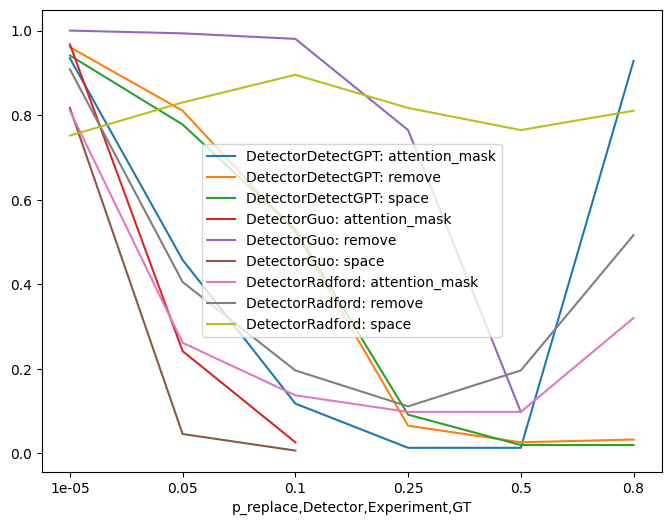

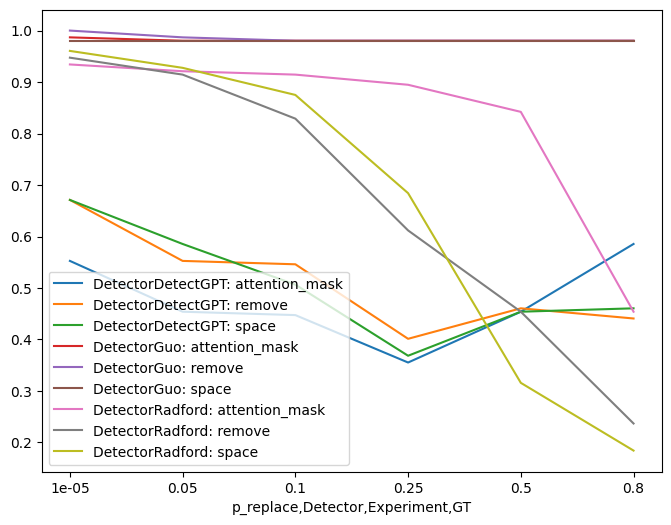

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

print("gt=machine")
for name, group in percentage_unchanged.groupby(["Detector", "Experiment","GT",]):
 #   display(group.index)
    if group.index[0][3]:
        continue
    group.plot(y="changed", ax=ax, label=": ".join(group.index[0][1:3]), legend=True)
    ax.set_xticklabels([item.get_text().split(",")[0][1:] for item in ax.get_xticklabels()])
    display()



fig, ax = plt.subplots(figsize=(8,6))
print("gt=human")
for name, group in percentage_unchanged.groupby(["Detector", "Experiment","GT",]):
    if not group.index[0][3]:
        continue
    group.plot(y="changed", ax=ax, label=": ".join(group.index[0][1:3]), legend=True)
    ax.set_xticklabels([item.get_text().split(",")[0][1:] for item in ax.get_xticklabels()])
    display()



## Conclusion
No masking strategy works best across all detectors and percentages masked. Note that none of these detectors were trained to support partial data. 
The masking strategy "attention_mask" is chosen for both LIME and SHAP for the following reasons:
- In SHAP, this is the method demonstrated in the documentation for transformer based models: [Doc 1](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html) [Doc 2](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html)
- For LIME, the default is either removing words or replacing them with a (user-defined) masking string. For the detector of Guo et al., "multiple space characters" appear to be an important feature utilized for detection (see discussion on H3 dataset). Using a masking string is therefore preferred over the removal of tokens or the addition of spaces here. LIME would otherwise be unable to highlight that feature as spaces (the sep token) are always collapsed in the default implementation.
- In the unprocessed dataset, human and ChatGPT-generated answers differed significantly in their average lengths. The last subplot here suggests that the detector from Guo et al. might utilize this fact (removing tokens does not flip the label for GT=human). Masking via the attention mask retains the length of the text. LIME would also collapse spaces.

To summarize: The best masking strategy differs by detector and percentage of words masked. Masking via the attention_mask is selected as it does not lead LIME to ignore the feature "multiple spaces", which would make its explanations unfaithful by default.